# Forecast

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines
import seaborn as sns


In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [4]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
#print(data)
#data = data.fillna(0) 
#data_cop = data.copy()
data = data.drop(columns=["Hour"])
#setup_forecast = data_cop.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()


In [5]:
Forecast_number = [1,2,3,4,5,6]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Noise_factor = [0,0.1,0.3,0.5,1,2]
Total_length_test = len(data["FD1_down"])

# Create an empty dataframe with the same columns as `data`
print(Total_length_test,len(Forecasts),len(Forecast_number))
forecasted_data_3D = np.zeros(( Total_length_test, len(Forecasts), len(Forecast_number) ))  # (Specific Forecasts, Data size, number of total forecasts )

print(np.shape(forecasted_data_3D))

10920 11 6
(10920, 11, 6)


In [6]:
# Create noise
std_col = np.std(data.loc[:, :],axis=0)
Uniform_Noise = np.random.uniform(-1, 1, (Total_length_test, len(Forecasts), len(Forecast_number)) )
print(np.shape(Uniform_Noise))

(10920, 11, 6)


In [7]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")

D_2_list = [3,4,5,6,7]

for col in data.columns:
    index = Forecasts.index(col) # Get the index

    for n, noise in enumerate(Noise_factor): # For each noise factor / forecast
    
    
        # Run mean procedure

        # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
        if 'percentage' in col:
                if "FD2" in col:
                    if "up" in col:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_up_percentage,n]
                    else:
                        forecasted_data_3D[:,index,n] = 1 - forecasted_data_3D[:,index_FD1_down_percentage,n]
                        #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
                else:
                    for h in range(24*7,Total_length_test): # Should start 
                        value = 0
                        for hd in D_2_list:

                            #print(data.loc[h+8760-hd*24, col])
                            #print(h+8760-hd*24)
                            value = value + data.loc[h + 0 -hd*24, col] + std_col[col] * noise * Uniform_Noise[h,index,n]
                        
                        forecasted_data_3D[h,index,n] = value/len(D_2_list)

        else:

            for h in range(24*7,Total_length_test):
                value = 0
                for hd in D_2_list:

                    #print(data.loc[h+8760-hd*24, col])
                    #print(h+8760-hd*24)
                    value = value + data.loc[h+0-hd*24, col] + std_col[col] * noise * Uniform_Noise[h,index,n]
                
                forecasted_data_3D[h,index,n] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [8]:
Forecast_number = [1, 2, 3, 4, 5, 6]
N_len = np.size(forecasted_data_3D[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

        errors = (True_data_arr[:,f] - forecasted_data_3D[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
    


        
        #df_describe = pd.DataFrame(MAPE_h)
        #print("         ", "Noise factor", " Feature","    Mean    ","        Median        ", "      Std      ")
        #print("Forecast-", Forecast_number[n], "-", Noise_factor[n],"    ",F[f],"   ", np.round(MAE), " ", np.round(Median_AE), " ", np.round(Std_AE))
        #print()
            
        # Save the proper data
        Saved_Info[n,f,0] = n 
        Saved_Info[n,f,1] = MAE
        Saved_Info[n,f,2] = Median_AE
        Saved_Info[n,f,3] = Std_AE


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast  0      Spot ( 81.0 63.0 70.0 )     FD1_down ( 34.0 9.0 84.0 )     FD2_down ( 8.0 3.0 13.0 )     FD1_up ( 29.0 16.0 41.0 )     FD2_up ( 8.0 4.0 10.0 )
Forecast  1      Spot ( 81.0 64.0 70.0 )     FD1_down ( 35.0 11.0 83.0 )     FD2_down ( 8.0 3.0 13.0 )     FD1_up ( 29.0 16.0 41.0 )     FD2_up ( 8.0 4.0 10.0 )
Forecast  2      Spot ( 84.0 66.0 71.0 )     FD1_down ( 39.0 19.0 83.0 )     FD2_down ( 9.0 5.0 13.0 )     FD1_up ( 31.0 18.0 41.0 )     FD2_up ( 9.0 7.0 10.0 )
Forecast  3      Spot ( 88.0 70.0 74.0 )     FD1_down ( 45.0 28.0 82.0 )     FD2_down ( 11.0 8.0 12.0 )     FD1_up ( 34.0 22.0 41.0 )     FD2_up ( 12.0 10.0 10.0 )
Forecast  4      Spot ( 107.0 90.0 82.0 )     FD1_down ( 63.0 48.0 83.0 )     FD2_down ( 15.0 13.0 13.0 )     FD1_up ( 44.0 35.0 42.0 )     FD2_up ( 19.0 18.0 13.0 )
Forecast  5      Spot ( 165.0 150.0 111.0 )     FD1_down ( 103.0 93.0 91.0 )     FD2_down ( 26.0 24.0 17.0 )     FD1_up ( 67.0 61.0 51.0 )     FD2_up ( 34.0 34.0 20.0 )


## plotting the error

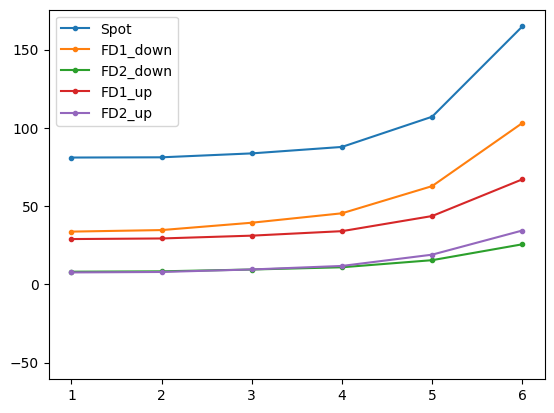

In [9]:
x = np.array(Forecast_number)

# plot for each feature
for f in range(0,F_len-6):
    
    MAE_f = Saved_Info[:,f,1]
    std_f = Saved_Info[:,f,3]
    plt.plot(x, MAE_f, label=F[f], marker='.')
    plt.fill_between(x, MAE_f-std_f, MAE_f-std_f, alpha=0.2)

plt.legend()
plt.show()

## Plot the hourly mean method

# Create a csv file for forecasted values of D-2

In [10]:

N_len = np.size(forecasted_data_3D[:,:,:],2)
F_len = np.size(forecasted_data_3D[:,:,:],0)
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    # change forecasted_data_3D to a dataframe
    df_forecast = pd.DataFrame(forecasted_data_3D[:,:,n], columns=F)
    
    #Create csv
    csv_name_path = path_processed_data+"forecast_all"+str(Forecast_number[n])+".csv"
    df_forecast.to_csv(csv_name_path,index=False)

In [15]:
forecastall = pd.read_csv(path_processed_data+"forecast_all1.csv")
real = pd.read_csv(path_processed_data+"real.csv")
forecast = pd.read_csv(path_processed_data+"forecast1.csv")

In [12]:
forecast.head()

,Spot,FD1_down,FD2_down,FD1_up,FD2_up,FD1_up_percentage,FD2_up_percentage,FD1_down_percentage,FD2_down_percentage,FD_act_up,FD_act_down
0,48.395999,117.888344,24.715378,34.026604,46.672286,0.119257,0.880743,0.388463,0.611537,0.000150,0.000881
1,38.726000,260.829358,26.246510,33.685540,46.638952,0.083436,0.916564,0.339880,0.660120,0.000067,0.001852
2,30.066000,257.748204,26.512626,32.520516,46.482934,0.100937,0.899063,0.338603,0.661397,0.000290,0.000225
3,23.825999,255.265618,26.493986,39.008504,46.507578,0.130143,0.869857,0.343053,0.656947,0.000634,0.004800
4,23.381999,219.311912,26.476464,39.555956,46.536942,0.121324,0.878676,0.340698,0.659302,0.000069,0.006563


In [14]:
forecastall.loc[8760].head()

Spot         48.395999
FD1_down    117.888344
FD2_down     24.715378
FD1_up       34.026604
FD2_up       46.672286
Name: 8760, dtype: float64

In [21]:
print(forecastall.loc[8760+24*3+1].head())
real.loc[8760+24*3+1].head()

Spot          8.216000
FD1_down    454.693874
FD2_down     53.548256
FD1_up       58.432512
FD2_up       47.163418
Name: 8833, dtype: float64


Hour        8833.000000
Spot          78.839996
FD1_down      24.025830
FD2_down      28.341100
FD1_up        39.537930
Name: 8833, dtype: float64